In [13]:
import numpy as np
import pandas as pd
import h5py
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import random
import json

In [14]:
data_dir = Path('../../data')
cello_dir = data_dir / 'CellO_data/bulk_RNA_seq_training_set'
split_dir = cello_dir / 'pretraining_validation_split'

In [3]:
exp_root = data_dir / 'experiments' / 'positive_b-split_256'
exp_root.mkdir(parents=True)

In [4]:
# transposing, so we have columns as features and rows as sample vectors
Y_df = pd.read_csv(data_dir / 'mat4.csv').transpose()
Y_df.shape

(4293, 55904)

In [11]:
Z_df = pd.read_csv(data_dir / 'plierResult-cello_train-256_dims/Z.csv')
Z_mat = Z_df.values
Z_df.shape

(5900, 256)

In [6]:
Z_genes = Z_df.index
print(f'{len(Z_genes)} genes in Z matrix')
z_in_y = Z_genes.isin(Y_df.columns).sum()
y_in_z = Y_df.columns.isin(Z_genes).sum()
print(f'{z_in_y * 100 / len(Z_genes)}% of them in matrix Y')
print(f'{y_in_z * 100 / len(Y_df.columns):0.2f}% of Y matrix genes in Z')

5900 genes in Z matrix
100.0% of them in matrix Y
10.55% of Y matrix genes in Z


In [7]:
Y_df = Y_df[Z_genes]
Y_df.shape

(4293, 5900)

In [15]:
with open(split_dir / 'validation_bulk_experiments.json', 'r') as f:
    validation_egs = json.load(f)

with open(split_dir / 'pre_training_bulk_experiments.json', 'r') as f:
    train_egs = json.load(f)

In [16]:
B_df = pd.read_csv(data_dir / 'plierResult-cello_train-256_dims/B.csv')
plier_train_egs = B_df.columns

In [19]:
assert set(plier_train_egs) == set(train_egs)

In [20]:
y_vectors = Y_df.values / Y_df.std().values
y_vectors.shape

(4293, 5900)

In [21]:
from sklearn.linear_model import LinearRegression

reg_nnls = LinearRegression(positive=True, n_jobs=8)

In [22]:
%%time
reg_nnls.fit(Z_mat, y_vectors.T)

Wall time: 8min 53s


LinearRegression(n_jobs=8, positive=True)

In [23]:
b_pos = np.array(reg_nnls.coef_)
b_pos.shape

(4293, 256)

In [24]:
b_intercept = reg_nnls.intercept_
b_intercept.shape

(4293,)

In [25]:
np.save(exp_root / 'b_pos.npy', b_pos)
np.save(exp_root / 'b_intercept.npy', b_intercept)
np.save(exp_root / 'samples.npy', Y_df.index.values)

In [26]:
y_hat_ = np.matmul(Z_mat, b_pos.transpose()).transpose()
y_hat_.shape

(4293, 5900)

In [28]:
y_hat = y_hat_ + b_intercept[:, None]

In [44]:
# number of vectors we'd like to find back
regr_subset_size = 200

target_inds = random.choices(range(len(b_pos)), k=regr_subset_size)

<AxesSubplot:>

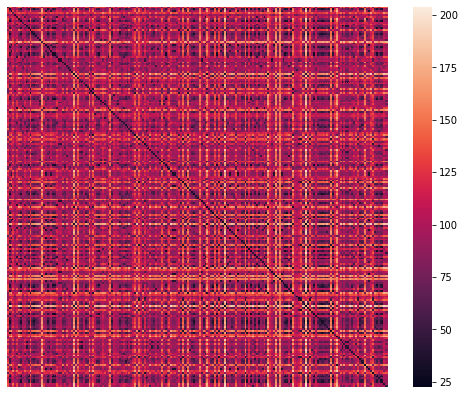

In [45]:
fig, ax = plt.subplots(1, 1, figsize = (9, 7))

y2y_hat_dists = scipy.spatial.distance.cdist(y_vectors[target_inds], y_hat[target_inds])
sns.heatmap(y2y_hat_dists,
    cbar=True,
    annot=False,
    square=True,
    fmt='.2f',
    xticklabels=[],
    yticklabels=[])

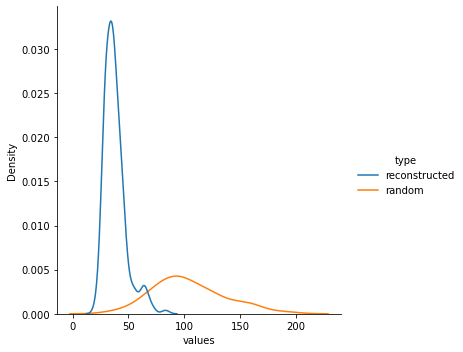

In [46]:
import pandas as pd

# distances between reconstructed Y vectors and associated target vectors
same_ind_dists = y2y_hat_dists.diagonal()

# get all values except the diagonal values
random_vectors_dists = y2y_hat_dists[~np.eye(y2y_hat_dists.shape[0], dtype=bool)]
random_vectors_dists = random.sample(list(random_vectors_dists), 100)

dists_df = pd.DataFrame({
    'values': list(same_ind_dists) + list(random_vectors_dists),
    'type': ['reconstructed'] * len(same_ind_dists) + ['random'] * len(random_vectors_dists)
})

sns.displot(data=dists_df, x='values', hue='type', kind='kde')

We could also compute the P-value based on these distributions.